In [1]:
from hftbacktest import BUY, SELL
from hftbacktest import HftBacktest, FeedLatency, Linear
from hftbacktest import SquareProbQueueModel, Stat, GTX
from matplotlib import pyplot as plt
from numba.typed import Dict
from numba import njit
from scipy import stats
import numpy as np
import pandas as pd

In [2]:
# Support And Resistance

@njit
def leftLimitExtract(bids, priceRangeLimit, halfSpreadLimit):
    res = []
    for bid in bids:
        price = float(bid[0])
        if price > halfSpreadLimit:
            continue
        if price < priceRangeLimit:
            break
        qty = float(bid[1])
        res.append([price, qty])
    return res


@njit
def rightLimitExtract(asks, priceRangeLimit, halfSpreadLimit):
  res = []   
  for ask in asks:
    price = float(ask[0])
    if price < halfSpreadLimit:
      continue
    if price > priceRangeLimit:
      break
    qty = float(ask[1])
    res.append([price,qty])
  return res



@njit
def histogram(data, weights, bins):
    # Compute the range of the data
    data_range = np.max(data) - np.min(data)
    
    # Compute the width of each bin
    bin_width = data_range / bins 
    
    # Initialize the histogram counts
    # counts = np.zeros(bins + 1, dtype=np.float64)
    counts = np.zeros(bins, dtype=np.float64)
    
    # Check if bin_width is 0
    if bin_width == 0:
        # Handle the case when bin_width is 0
        # For example, return an empty histogram
        return counts, np.array([np.min(data), np.max(data)])
    
    # Loop over the data points and accumulate the counts
    for i in range(len(data)):
        # Compute the bin index for this data point
        bin_index = int((data[i] - np.min(data)) // bin_width)
        
        # Add the weight of this data point to the appropriate bin
        counts[bin_index] += weights[i]
    
    # Compute the bin edges
    bin_edges = np.linspace(np.min(data), np.max(data), bins+1)
    
    return counts, bin_edges

@njit
def getSupportResistance(bids, asks, lineNumber=5):
    
    binNum = 50
    
    support = []    
    if bids:
        arr_bids = np.array(bids) 
        x_bids, y_bids = histogram(arr_bids[:, 0],arr_bids[:, 1], binNum)
        y_bids = [(y_bids[i] + y_bids[i-1])/2 for i in range(1, len(y_bids))]
        y_bids = np.asarray(y_bids, dtype=np.float64)
        x_bids = np.asarray(x_bids, dtype=np.float64)

        for i in range(y_bids.shape[0]):
            row = []
            row.append(y_bids[i])
            row.append(x_bids[i])
            support.append(row)
        support.sort(key=lambda x: x[1], reverse=True)
    
    resistance = []
    if asks:
        arr_asks = np.array(asks) 
        x_asks, y_asks = histogram(arr_asks[:, 0],arr_asks[:, 1], binNum)  
        y_asks = [(y_asks[i] + y_asks[i-1])/2 for i in range(1, len(y_asks))]
        y_asks = np.asarray(y_asks, dtype=np.float64)
        x_asks = np.asarray(x_asks, dtype=np.float64)
        for i in range(y_asks.shape[0]):
            row = []
            row.append(y_asks[i])
            row.append(x_asks[i])
            resistance.append(row)
        resistance.sort(key=lambda x: x[1], reverse=True)
    
    # print(resistance)
    return support[:lineNumber], resistance[:lineNumber]

In [3]:
@njit
def measure_trading_intensity_and_volatility(hbt):
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        t += 1
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
    return arrival_depth[:t], mid_price_chg[:t]

In [4]:
@njit
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        
        # Sets the tick index to 0 for the nearest possible best price 
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1
        
        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades) 
        # since the mid-price is measured in a previous time-step; 
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue
        
        # All of our possible quotes within the order arrival depth, 
        # excluding those at the same price, are considered executed.
        out[:tick] += 1
        
        max_tick = max(max_tick, tick)
    return out[:max_tick]

In [5]:
@njit
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2

In [6]:
@njit
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept

In [7]:
@njit
def gridtrading_glft_mm(hbt, stat):
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)
    out = np.full((10_000_000, 5), np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + .5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    adj2 = 0.05

    order_qty = 1
    max_position = 2000
    grid_num = 20
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                lambda_ = lambda_[:70] / 600
                x = ticks[:len(lambda_)]
                y = np.log(lambda_)
                k_, logA = linear_regression(x, y)
                A = np.exp(logA)
                k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
    
        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)
        
        half_spread = (c1 + 1 / 2 * c2 * volatility) * adj1
        skew = c2 * volatility * adj2
        
        bid_depth = half_spread + skew * hbt.position
        ask_depth = half_spread - skew * hbt.position
    
        # If the depth is invalid, set a large spread to prevent execution.
        if not np.isfinite(bid_depth):
            bid_depth = 1_000
        if not np.isfinite(ask_depth):
            ask_depth = 1_000

        bid_price = min(round(mid_price_tick - bid_depth), hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(round(mid_price_tick + ask_depth), hbt.best_ask_tick) * hbt.tick_size
        
        order_interval = round(max(half_spread, 1)) * hbt.tick_size if (not np.isnan(half_spread)) else hbt.tick_size
        bid_price = np.floor(bid_price / order_interval) * order_interval
        ask_price = np.ceil(ask_price / order_interval) * order_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        
        ###############SSUPORT RESSITANCSE
        ## Get market depth
        mid_price = np.floor(mid_price_tick * hbt.tick_size / order_interval) * order_interval
        depth_market = 100
        bid = []
        ask = []
        i = 0
        for tick_price in range(hbt.best_ask_tick, hbt.high_ask_tick + 1):
            if tick_price in hbt.ask_depth:
                ask.append([tick_price * hbt.tick_size, hbt.ask_depth[tick_price]])
                i += 1
                if i == depth_market:
                    break
        i = 0
        for tick_price in range(hbt.best_bid_tick, hbt.low_bid_tick - 1, -1):
            if tick_price in hbt.bid_depth:
                bid.append([tick_price * hbt.tick_size, hbt.bid_depth[tick_price]])
                i += 1
                if i == depth_market:
                    break
                    
                    
        lineNumber = 5
        
        bids = leftLimitExtract(bid, mid_price - order_interval * grid_num, min(bid_price, hbt.best_bid))
        asks = rightLimitExtract(ask, mid_price + order_interval * grid_num, max(ask_price, hbt.best_ask))
        
        
        supportLevel, resistanceLevel = getSupportResistance(bid, ask, lineNumber) 
        
        
        
        #############
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position:
#             for i in range(grid_num):
#                 bid_price -= i * order_interval
#                 bid_price_tick = round(bid_price / hbt.tick_size)
                
#                 # order price in tick is used as order id.
#                 new_bid_orders[bid_price_tick] = bid_price
            for bid in supportLevel:                
                bid_order_price = bid[0] # supportLevel = [[0.01254, 11310.9], [0.0125, 3453.6]....]
                bid_order_tick = round(bid_order_price / hbt.tick_size)
                # order price in tick is used as order id.
                new_bid_orders[bid_order_tick] = bid_order_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position:
#             for i in range(grid_num):
#                 ask_price += i * order_interval
#                 ask_price_tick = round(ask_price / hbt.tick_size)
                
#                 # order price in tick is used as order id.
#                 new_ask_orders[ask_price_tick] = ask_price
                        ## RESISTANCE 
            for ask in resistanceLevel:  
                ask_order_price = ask[0] # resistanceLevel = [[0.01254, 11310.9], [0.0125, 3453.6]....]
                ask_order_tick = round(ask_order_price / hbt.tick_size)
                # Do not post sell orders below the best ask and above grid range

                # order price in tick is used as order id.
                new_ask_orders[ask_order_tick] = ask_order_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
                
        #--------------------------------------------------------
        # Records variables and stats for analysis.
        
        out[t, 0] = half_spread
        out[t, 1] = skew
        out[t, 2] = volatility
        out[t, 3] = A
        out[t, 4] = k
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg) or t >= len(out):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)
    return out[:t]

Load ./CollectData/data/btcusdt_20230516.npz
=========== Summary ===========
Sharpe ratio: 14.9
Sortino ratio: 17.3
Risk return ratio: 575.9
Annualised return: 465423.48 %
Max. draw down: 808.21 %
The number of trades per day: 9840
Avg. daily trading volume: 9840
Avg. daily trading amount: 267822408
Max leverage: 2313.74
Median leverage: 394.80


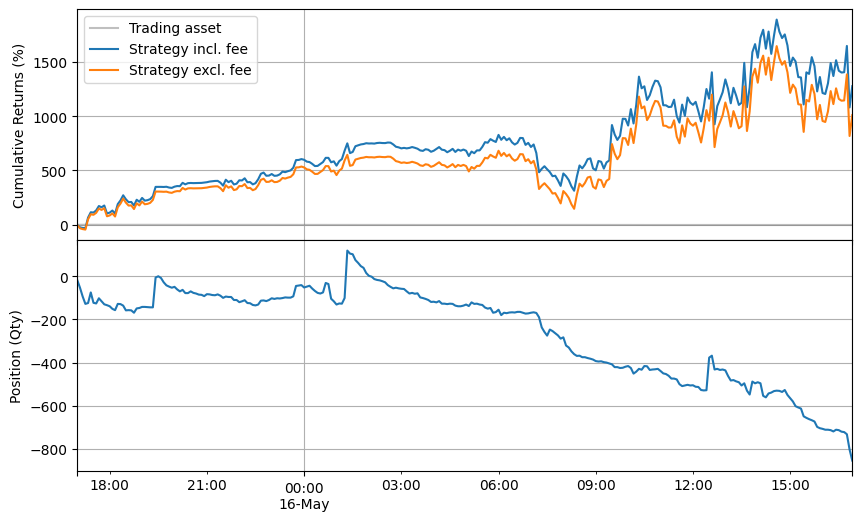

In [8]:
hbt = HftBacktest(
    [
        './CollectData/data/btcusdt_20230516.npz',
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    trade_list_size=10_000,
    snapshot='./CollectData/data/btcusdt_20230515_eod.npz'
)

stat = Stat(hbt)

out = gridtrading_glft_mm(hbt, stat.recorder)

stat.summary(capital=10_000)

Text(0, 0.5, 'Skew (tick)')

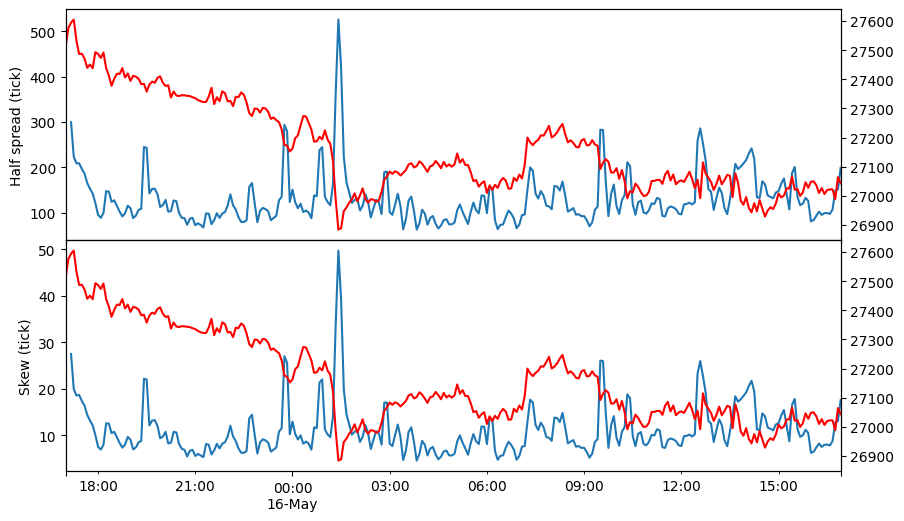

In [9]:
dt = stat.datetime()

mid = pd.Series(stat.mid, index=dt)
half_spread = pd.Series(out[:, 0], index=dt)
skew = pd.Series(out[:, 1], index=dt)
volatility = pd.Series(out[:, 2], index=dt)
A = pd.Series(out[:, 3], index=dt)
k = pd.Series(out[:, 4], index=dt)

fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(10, 6)

half_spread.resample('5min').last().plot(ax=axs[0])
mid.resample('5min').last().plot(ax=axs[0].twinx(), style='r')
axs[0].set_ylabel('Half spread (tick)')

skew.resample('5min').last().plot(ax=axs[1])
mid.resample('5min').last().plot(ax=axs[1].twinx(), style='r')
axs[1].set_ylabel('Skew (tick)')

Text(0, 0.5, 'k ($ tick^{-1} $)')

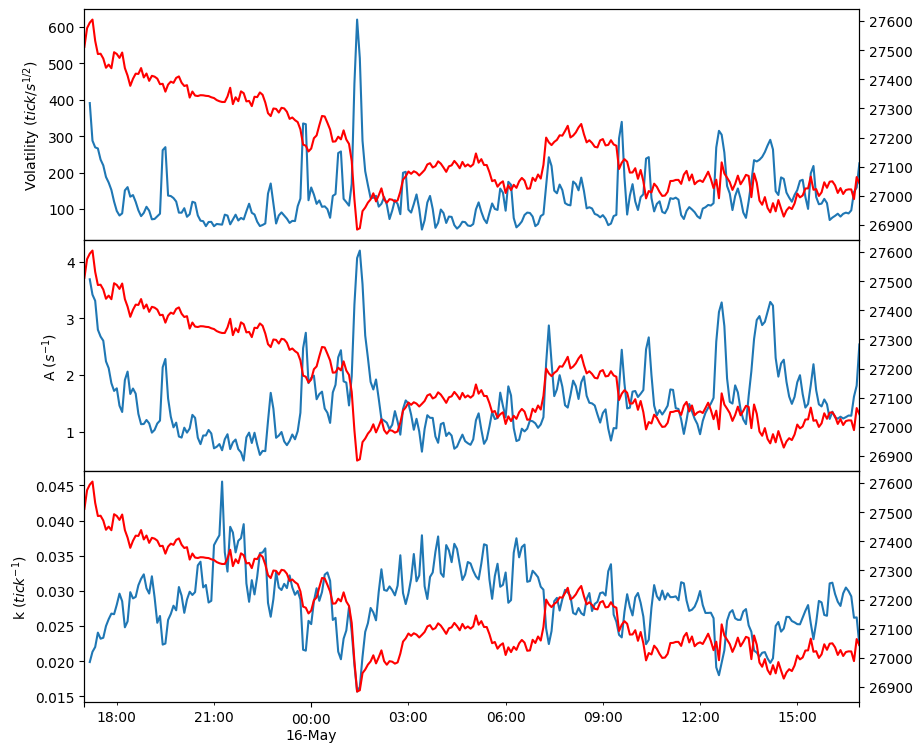

In [10]:
fig, axs = plt.subplots(3, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(10, 9)

volatility.resample('5min').last().plot(ax=axs[0])
mid.resample('5min').last().plot(ax=axs[0].twinx(), style='r')
axs[0].set_ylabel('Volatility ($ tick/s^{1/2} $)')

A.resample('5min').last().plot(ax=axs[1])
mid.resample('5min').last().plot(ax=axs[1].twinx(), style='r')
axs[1].set_ylabel('A ($ s^{-1} $)')

k.resample('5min').last().plot(ax=axs[2])
mid.resample('5min').last().plot(ax=axs[2].twinx(), style='r')
axs[2].set_ylabel('k ($ tick^{-1} $)')